In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import math
import numpy as np
import copy
import time
import pickle
from random import seed, shuffle, sample

from sklearn.preprocessing import StandardScaler
from aif360.datasets import AdultDataset, CompasDataset, GermanDataset, BankDataset, StandardDataset

import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [2]:
sys.path.append('../baselines/iFair/')
sys.path.append('../baselines/LFR/')
sys.path.append('../baselines/PFR/')
sys.path.append('../iFlipper/')

from iflipper import iFlipper
from aif360.algorithms.preprocessing import LFR
from iFair import iFair
from PFR import PFR, similarity_pfr, estimate_dim

from cplex_solver import CPLEX_Solver
from greedy import Greedy
from gradient import Gradient

from utils import measure_violations, similarity_knn, similarity_threshold
from model import Model

# Load fairness dataset from AIF360 and define variables
### 1. Dataset = COMPAS, AdultCensus, Credit
### 2. Similarity matrix = knn, threshold
### 3. ML model = LogisticRegression, RandomForest, NeuralNetwork

In [3]:
dataset_type = "COMPAS" # AdultCensus, Credit
similarity_matrix = "knn" # threshold
model_type = "LogisticRegression" # RandomForest, NeuralNetwork

In [4]:
if dataset_type == "COMPAS":
    dataset = CompasDataset(label_name='two_year_recid', favorable_classes=[0], 
                            protected_attribute_names=['sex'], privileged_classes=[['Female']], 
                            categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc', 'race'], 
                            features_to_keep=['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'two_year_recid'], 
                            features_to_drop=[], na_values=[])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1
    k, threshold = 20, 3
    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.001, 0]
    
elif dataset_type == "AdultCensus":
    dataset = AdultDataset(label_name='income-per-year', favorable_classes=['>50K', '>50K.'], 
                    protected_attribute_names=['sex'], privileged_classes=[['Male']], 
                    categorical_features=['race', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'], 
                    features_to_keep=[], features_to_drop=['fnlwgt'], na_values=['?'])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1
    k, threshold = 20, 3
    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 0]
    
elif dataset_type == "Credit":
    def label_processing(df):
        credit_map = {1.0 : 1.0, 2.0 : 0.0}
        status_map = {'A91': 'male', 'A93': 'male', 'A94': 'male',
                      'A92': 'female', 'A95': 'female'}
        df['credit'] = df['credit'].replace(credit_map)
        df['sex'] = df['personal_status'].replace(status_map)    
        return df
    
    dataset = GermanDataset(custom_preprocessing = label_processing, 
                            metadata={'label_maps': [{1.0: 'Good Credit', 0.0: 'Bad Credit'}], 'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, {1.0: 'Old', 0.0: 'Young'}]})
    protected = "age"
    num_train, num_test, num_val = 0.7, 0.2, 0.1
    k, threshold = 20, 7
    num_plot = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]

privileged_groups = [{protected: 1}]
unprivileged_groups = [{protected: 0}]

In [5]:
scaler = StandardScaler()
train, test, val = dataset.split([num_train, num_train+num_test], shuffle=True, seed=0)

train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)
val.features = scaler.fit_transform(val.features)
index = train.feature_names.index(protected)

# remove sensitive features
x_train = np.delete(train.features, index, axis=1)
x_test = np.delete(test.features, index, axis=1)
x_val = np.delete(val.features, index, axis=1)

y_train = train.labels.ravel()
y_test = test.labels.ravel()
y_val = val.labels.ravel()

# keep sensitive column for PFR
train_sensitive = np.reshape(train.features[:, index], (-1, 1))
test_sensitive = np.reshape(test.features[:, index], (-1, 1))
val_sensitive = np.reshape(val.features[:, index], (-1, 1))

# For iFair
x_train_with_sensitive = np.concatenate((x_train, train_sensitive), axis = 1)
x_test_with_sensitive = np.concatenate((x_test, test_sensitive), axis = 1)
x_val_with_sensitive = np.concatenate((x_val, val_sensitive), axis = 1)

print("Dataset: %s" % dataset_type)
print("Number of training data: %d, Number of test data: %d, Number of validation data: %d\n" % (x_train.shape[0], x_test.shape[0], x_val.shape[0]))

Dataset: COMPAS
Number of training data: 3700, Number of test data: 1850, Number of validation data: 617



# Obtain similarity matrix

In [6]:
if similarity_matrix == "knn":
    w_train, edge_train = similarity_knn(x_train, k)
    w_test, edge_test = similarity_knn(x_test, k)
    w_val, edge_val = similarity_knn(x_val, k)
    
elif similarity_matrix == "threshold":
    w_train, edge_train = similarity_threshold(x_train, threshold)
    w_test, edge_test = similarity_threshold(x_test, threshold)
    w_val, edge_val = similarity_threshold(x_val, threshold)

# Original result (without any pre-processing)

In [7]:
test_accuracy, test_consistency_score, runtime = dict(), dict(), dict()

model = Model(model_type, x_train, y_train, w_train, edge_train, x_test, y_test, w_test, edge_test, x_val, y_val)
train_performance, test_performance = model.train()

test_accuracy["Original"], test_consistency_score["Original"] = [test_performance[0]], [test_performance[1]]
print(f"Test Accuracy: {test_performance[0]:.5f}")
print(f"Test Consistency Score: {test_performance[1]:.5f}")

Test Accuracy: 0.68811
Test Consistency Score: 0.72307


# iFlipper on different target violation limits (m)

In [8]:
method = "iFlipper"
test_accuracy[method], test_consistency_score[method], runtime[method] = [], [], []

init_violations = measure_violations(y_train, edge_train)
print(f"Initial number of violations: {init_violations}")

for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    IFLIP = iFlipper(y_train, w_train, edge_train)
    flipped_label = IFLIP.transform(m)
    elapsed_time = time.time() - start

    model = Model(model_type, x_train, flipped_label, w_train, edge_train, x_test, y_test, w_test, edge_test, x_val, y_val)
    train_performance, test_performance = model.train()

    test_accuracy[method].append(test_performance[0])
    test_consistency_score[method].append(test_performance[1])
    runtime[method].append(elapsed_time)
    
    print("============================")
    print(f"Target number of violations: {m}")
    print(f"Actual number of violations: {measure_violations(flipped_label, edge_train)}")
    print(f"Number of flips: {np.sum(y_train != flipped_label)}")
    print(f"Test Accuracy: {test_performance[0]:.5f}") 
    print(f"Test Consistency Score: {test_performance[1]:.5f}")
    print(f"Runtime (sec): {elapsed_time:.5f}")

Initial number of violations: 22327
Target number of violations: 22327
Actual number of violations: 22327
Number of flips: 0
Test Accuracy: 0.68811
Test Consistency Score: 0.72307
Runtime (sec): 0.00049
Target number of violations: 17861
Actual number of violations: 17854
Number of flips: 192
Test Accuracy: 0.68378
Test Consistency Score: 0.75177
Runtime (sec): 6.49843
Target number of violations: 13396
Actual number of violations: 13390
Number of flips: 445
Test Accuracy: 0.67405
Test Consistency Score: 0.78291
Runtime (sec): 6.19294
Target number of violations: 8930
Actual number of violations: 8916
Number of flips: 734
Test Accuracy: 0.65405
Test Consistency Score: 0.80060
Runtime (sec): 7.06196
Target number of violations: 4465
Actual number of violations: 4453
Number of flips: 1069
Test Accuracy: 0.63730
Test Consistency Score: 0.83435
Runtime (sec): 7.66725
Target number of violations: 2232
Actual number of violations: 2226
Number of flips: 1274
Test Accuracy: 0.62216
Test Consis

# Accuracy-fairness trade-off for iFlipper

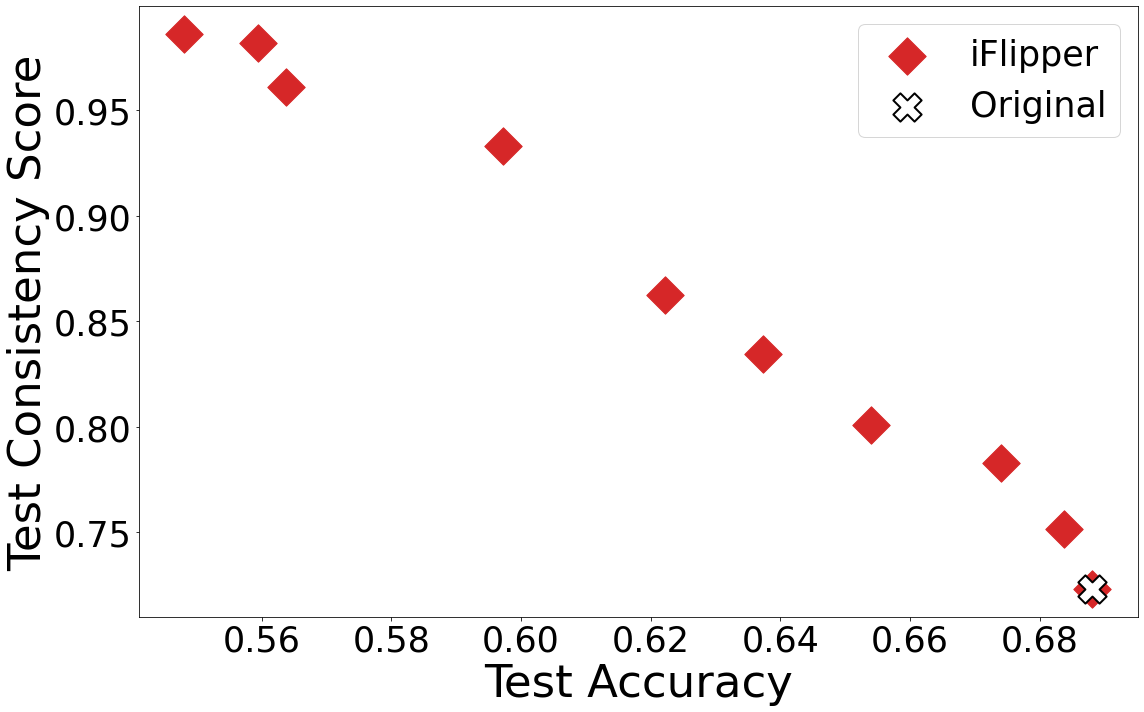

In [9]:
methods = ["iFlipper", "Original"]
shapes = ["D", "X"]
marker_size = 700

plt.figure(figsize=(16, 10))
for i in range(len(methods)):
    if methods[i] == "Original":
        plt.scatter(test_accuracy[methods[i]], test_consistency_score[methods[i]], label=methods[i], s=marker_size+100, marker=shapes[i], edgecolors="black", linewidth=2, color="white")
    else:
        plt.scatter(test_accuracy[methods[i]], test_consistency_score[methods[i]], label=methods[i], s=marker_size, marker=shapes[i], color="tab:red") 
        
plt.tick_params(labelsize=35)
plt.xlabel("Test Accuracy", fontsize=45)
plt.ylabel("Test Consistency Score", fontsize=45)
plt.legend(prop={'size':35})

plt.tight_layout()
plt.show()